In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


## 数据加载

In [2]:
import unicodedata
import re
from sklearn.model_selection import train_test_split

#因为西班牙语有一些是特殊字符，所以我们需要unicode转ascii，
# 这样值变小了，因为unicode太大
def unicode_to_ascii(s):
    #NFD是转换方法，把每一个字节拆开，Mn是重音，所以去除
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

#下面我们找个样本测试一下
# 加u代表对字符串进行unicode编码
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))




May I borrow this book?
¿Puedo tomar prestado este libro?


In [3]:
def preprocess_sentence(w):
    #变为小写，去掉多余的空格，变成小写，id少一些
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # eg: "he is a boy." => "he is a boy . "
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    #因为可能有多余空格，替换为一个空格，所以处理一下
    w = re.sub(r'[" "]+', " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    return w

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))  #¿是占用两个字节的

may i borrow this book ?
¿ puedo tomar prestado este libro ?
b'\xc2\xbf puedo tomar prestado este libro ?'


Dataset

In [4]:
#zip例子
a = [[1,2],[4,5],[7,8]]
zipped = list(zip(*a))
print(zipped)

[(1, 4, 7), (2, 5, 8)]


In [5]:
split_index1 = np.random.choice(a=["train", "test"], replace=True, p=[0.9, 0.1], size=100)
split_index1

array(['train', 'test', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'test', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'test', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'test', 'train', 'train', 'train', 'train', 'train',
       'train', 'test', 'train', 'test', 'train', 'train', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train'], dty

In [6]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

class LangPairDataset(Dataset):
    fpath = Path(r"./data_spa_en/spa.txt") #数据文件路径
    cache_path = Path(r"./.cache/lang_pair.npy") #缓存文件路径
    split_index = np.random.choice(a=["train", "test"], replace=True, p=[0.9, 0.1], size=118964) #按照9:1划分训练集和测试集
    def __init__(self, mode="train", cache=False):
        if cache or not self.cache_path.exists():#如果没有缓存，或者缓存不存在，就处理一下数据
            self.cache_path.parent.mkdir(parents=True, exist_ok=True) #创建缓存文件夹，如果存在就忽略
            with open(self.fpath, "r", encoding="utf8") as file:
                lines = file.readlines()
                lang_pair = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines] #处理数据，变成list((src, trg))的形式
                trg, src = zip(*lang_pair) #分离出目标语言和源语言
                trg=np.array(trg) #转换为numpy数组
                src=np.array(src) #转换为numpy数组
                np.save(self.cache_path, {"trg": trg, "src": src})  #保存为npy文件,方便下次直接读取,不用再处理
        else:
            lang_pair = np.load(self.cache_path, allow_pickle=True).item() #读取npy文件，allow_pickle=True允许读取字典
            trg = lang_pair["trg"]
            src = lang_pair["src"]

        self.trg = trg[self.split_index == mode] #按照index拿到训练集的 标签语言 --英语
        self.src = src[self.split_index == mode] #按照index拿到训练集的源语言 --西班牙

    def __getitem__(self, index):
        return self.src[index], self.trg[index]

    def __len__(self):
        return len(self.src)


train_ds = LangPairDataset("train")
test_ds = LangPairDataset("test")

In [7]:
print("source: {}\ntarget: {}".format(*train_ds[-1]))

source: si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado .
target: if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo .


### Tokenizer

这里有两种处理方式，分别对应着 encoder 和 decoder 的 word embedding 是否共享，这里实现不共享的方案。

In [8]:
from collections import Counter

def get_word_idx(ds, mode="src", threshold=2):
    #载入词表，看下词表长度，词表就像英语字典
    word2idx = {
        "[PAD]": 0,     # 填充 token
        "[BOS]": 1,     # begin of sentence
        "[UNK]": 2,     # 未知 token
        "[EOS]": 3,     # end of sentence
    }
    idx2word = {value: key for key, value in word2idx.items()}
    index = len(idx2word)
    threshold = 1  # 出现次数低于此的token舍弃
    #如果数据集有很多个G，那是用for循环的，不能' '.join
    word_list = " ".join([pair[0 if mode=="src" else 1] for pair in ds]).split()
    counter = Counter(word_list) #统计词频,counter类似字典，key是单词，value是出现次数
    print("word count:", len(counter))

    for token, count in counter.items():
        if count >= threshold:#出现次数大于阈值的token加入词表
            word2idx[token] = index #加入词表
            idx2word[index] = token #加入反向词表
            index += 1

    return word2idx, idx2word

src_word2idx, src_idx2word = get_word_idx(train_ds, "src") #源语言词表
trg_word2idx, trg_idx2word = get_word_idx(train_ds, "trg") #目标语言词表

word count: 23715
word count: 12500


In [9]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=500, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.unk_idx = unk_idx

    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """如果padding_first == True，则padding加载前面，否则加载后面
        return_mask: 是否返回mask(掩码），mask用于指示哪些是padding的，哪些是真实的token
        """
        max_length = min(self.max_length, add_eos + add_bos + max([len(text) for text in text_list]))
        indices_list = []
        for text in text_list:
            indices = [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - add_bos - add_eos]] #如果词表中没有这个词，就用unk_idx代替，indices是一个list,里面是每个词的index,也就是一个样本的index
            if add_bos:
                indices = [self.bos_idx] + indices
            if add_eos:
                indices = indices + [self.eos_idx]
            if padding_first:#padding加载前面，超参可以调
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:#padding加载后面
                indices = indices + [self.pad_idx] * (max_length - len(indices))
            indices_list.append(indices)
        input_ids = torch.tensor(indices_list) #转换为tensor
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64) #mask是一个和input_ids一样大小的tensor，0代表token，1代表padding，mask用于去除padding的影响
        return input_ids if not return_mask else (input_ids, masks)


    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]") #如果词表中没有这个词，就用unk_idx代替
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":#如果到达eos，就结束
                    break
                if remove_pad and word == "[PAD]":#如果到达pad，就结束
                    break
                text.append(word) #单词添加到列表中
            text_list.append(" ".join(text) if not split else text) #把列表中的单词拼接，变为一个句子
        return text_list

#两个相对于1个toknizer的好处是embedding的参数量减少
src_tokenizer = Tokenizer(word2idx=src_word2idx, idx2word=src_idx2word) #源语言tokenizer
trg_tokenizer = Tokenizer(word2idx=trg_word2idx, idx2word=trg_idx2word) #目标语言tokenizer

# trg_tokenizer.encode([["hello"], ["hello", "world"]], add_bos=True, add_eos=False,return_mask=True)
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
indices,mask = trg_tokenizer.encode(raw_text, padding_first=False, add_bos=True, add_eos=True,return_mask=True)
decode_text = trg_tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)
print("raw text"+'-'*10)
for raw in raw_text:
    print(raw)
print("mask"+'-'*10)
for m in mask:
    print(m)
print("indices"+'-'*10)
for index in indices:
    print(index)
print("decode text"+'-'*10)
for decode in decode_text:
    print(decode)

raw text----------
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
mask----------
tensor([0, 0, 0, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1])
indices----------
tensor([   1,   16, 3218,    3,    0,    0,    0])
tensor([   1,    2, 3878,    2,  552,    2,    3])
tensor([   1,  117,  235,  103, 2896,    3,    0])
decode text----------
[BOS] hello world [EOS] [PAD] [PAD] [PAD]
[BOS] [UNK] text [UNK] with [UNK] [EOS]
[BOS] this is a test [EOS] [PAD]


### DataLoader

In [10]:
def collate_fct(batch):
    src_words = [pair[0].split() for pair in batch]
    trg_words = [pair[1].split() for pair in batch]

    # [PAD] [BOS] src [EOS]
    encoder_inputs, encoder_inputs_mask = src_tokenizer.encode(
        src_words, padding_first=True, add_bos=True, add_eos=True, return_mask=True
        )

    # [BOS] trg [PAD]
    decoder_inputs = trg_tokenizer.encode(
        trg_words, padding_first=False, add_bos=True, add_eos=False, return_mask=False,
        )

    # trg [EOS] [PAD]
    decoder_labels, decoder_labels_mask = trg_tokenizer.encode(
        trg_words, padding_first=False, add_bos=False, add_eos=True, return_mask=True
        )

    return {
        "encoder_inputs": encoder_inputs.to(device=device),
        "encoder_inputs_mask": encoder_inputs_mask.to(device=device),
        "decoder_inputs": decoder_inputs.to(device=device),
        "decoder_labels": decoder_labels.to(device=device),
        "decoder_labels_mask": decoder_labels_mask.to(device=device),
    } #当返回的数据较多时，用dict返回比较合理


In [11]:
sample_dl = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fct)

for batch in sample_dl:
    for key, value in batch.items():
        print(key)
        print(value)
    break

encoder_inputs
tensor([[   0,    1,   55,   67, 1056,  306,   50,    5,    3],
        [   1,   92, 5604,   50, 2622,  489, 3758,    5,    3]],
       device='cuda:0')
encoder_inputs_mask
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
decoder_inputs
tensor([[   1,   17,   32,  516,   30, 1088, 1577,    5,    0],
        [   1,   47, 2976,  689, 5400, 2238,  634,   29,    5]],
       device='cuda:0')
decoder_labels
tensor([[  17,   32,  516,   30, 1088, 1577,    5,    3,    0],
        [  47, 2976,  689, 5400, 2238,  634,   29,    5,    3]],
       device='cuda:0')
decoder_labels_mask
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


## 定义模型

In [12]:
class Encoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=256,
        hidden_dim=1024,
        num_layers=1,
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)

    def forward(self, encoder_inputs):
        # encoder_inputs.shape = [batch size, sequence length]
        # bs, seq_len = encoder_inputs.shape
        embeds = self.embedding(encoder_inputs)
        # embeds.shape = [batch size, sequence length, embedding_dim]->[batch size, sequence length, hidden_dim]
        seq_output, hidden = self.gru(embeds)
        # seq_output.shape = [batch size, sequence length, hidden_dim]，hidden.shape [ num_layers, batch size, hidden_dim]
        return seq_output, hidden

In [13]:
#把上面的Encoder写一个例子，看看输出的shape
encoder = Encoder(vocab_size=100, embedding_dim=256, hidden_dim=1024, num_layers=4)
encoder_inputs = torch.randint(0, 100, (2, 50))
encoder_outputs, hidden = encoder(encoder_inputs)
print(encoder_outputs.shape)
print(hidden.shape)
print(encoder_outputs[:,-1,:])
print(hidden[-1,:,:]) #取最后一层的hidden

torch.Size([2, 50, 1024])
torch.Size([4, 2, 1024])
tensor([[-0.0636,  0.0092,  0.0103,  ..., -0.0153, -0.0004, -0.0341],
        [-0.0175,  0.0283,  0.0105,  ...,  0.0142,  0.0282, -0.0413]],
       grad_fn=<SliceBackward0>)
tensor([[-0.0636,  0.0092,  0.0103,  ..., -0.0153, -0.0004, -0.0341],
        [-0.0175,  0.0283,  0.0105,  ...,  0.0142,  0.0282, -0.0413]],
       grad_fn=<SliceBackward0>)


In [14]:
query1 = torch.randn(2, 1024)
query1.unsqueeze(1).shape #增加维度

torch.Size([2, 1, 1024])

In [15]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim=1024):
        super().__init__()
        self.Wk = nn.Linear(hidden_dim, hidden_dim) #对keys做运算，encoder的输出EO
        self.Wq = nn.Linear(hidden_dim, hidden_dim) #对query做运算，decoder的隐藏状态
        self.V = nn.Linear(hidden_dim, 1)

    def forward(self, query, keys, values, attn_mask=None):
        """
        正向传播
        :param query: hidden state，是decoder的隐藏状态，shape = [batch size, hidden_dim]
        :param keys: EO  [batch size, sequence length, hidden_dim]
        :param values: EO  [batch size, sequence length, hidden_dim]
        :param attn_mask:[batch size, sequence length]
        :return:
        """
        # query.shape = [batch size, hidden_dim] -->通过unsqueeze(-2)增加维度 [batch size, 1, hidden_dim]
        # keys.shape = [batch size, sequence length, hidden_dim]
        # values.shape = [batch size, sequence length, hidden_dim]
        scores = self.V(F.tanh(self.Wk(keys) + self.Wq(query.unsqueeze(-2)))) #unsqueeze(-2)增加维度
        # score.shape = [batch size, sequence length, 1]
        if attn_mask is not None: #这个mask是encoder_inputs_mask，用来mask掉padding的部分,让padding部分socres为0
            # attn_mask is a matrix of 0/1 element,
            # 1 means to mask logits while 0 means do nothing
            # here we add -inf to the element while mask == 1
            attn_mask = (attn_mask.unsqueeze(-1)) * -1e16 #在最后增加一个维度，[batch size, sequence length] --> [batch size, sequence length, 1]
            scores += attn_mask
        scores = F.softmax(scores, dim=-2) #对每一个词的score做softmax
        # score.shape = [batch size, sequence length, 1]
        context_vector = torch.mul(scores, values).sum(dim=-2) #对每一个词的score和对应的value做乘法，然后在seq_len维度上求和，得到context_vector
        # context_vector.shape = [batch size, hidden_dim]
        #socres用于最后的画图
        return context_vector, scores


In [16]:
#tensor矩阵相乘
a = torch.randn(2, 3)
b = torch.randn(3, 2)
c = torch.mm(a, b) #增加维度
print(c.shape)

torch.Size([2, 2])


In [17]:
#把上面的BahdanauAttention写一个例子，看看输出的shape
attention = BahdanauAttention(hidden_dim=1024)
query = torch.randn(2, 1024) #Decoder的隐藏状态
keys = torch.randn(2, 50, 1024) #EO
values = torch.randn(2, 50, 1024) #EO
attn_mask = torch.randint(0, 2, (2, 50))
context_vector, scores = attention(query, keys, values, attn_mask)
print(context_vector.shape)
print(scores.shape)

torch.Size([2, 1024])
torch.Size([2, 50, 1])


In [18]:
class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=256,
        hidden_dim=1024,
        num_layers=1,
        ):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim + hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size) #最后分类
        self.dropout = nn.Dropout(0.6)
        self.attention = BahdanauAttention(hidden_dim) #注意力得到的context_vector

    def forward(self, decoder_input, hidden, encoder_outputs, attn_mask=None):
        #attn_mask是encoder_inputs_mask
        # decoder_input.shape = [batch size, 1]
        assert len(decoder_input.shape) == 2 and decoder_input.shape[-1] == 1, f"decoder_input.shape = {decoder_input.shape}"
        # hidden.shape = [batch size, hidden_dim]，decoder_hidden,而第一次使用的是encoder的hidden
        assert len(hidden.shape) == 2, f"hidden.shape = {hidden.shape}"
        # encoder_outputs.shape = [batch size, sequence length, hidden_dim]
        assert len(encoder_outputs.shape) == 3, f"encoder_outputs.shape = {encoder_outputs.shape}"

        context_vector, attention_score = self.attention(
            query=hidden, keys=encoder_outputs, values=encoder_outputs, attn_mask=attn_mask)
        # context_vector.shape = [batch size, hidden_dim]
        embeds = self.embedding(decoder_input)
        # embeds.shape = [batch size, 1, embedding_dim]
        embeds = torch.cat([context_vector.unsqueeze(-2), embeds], dim=-1)
        # embeds.shape = [batch size, 1, embedding_dim + hidden_dim]
        seq_output, hidden = self.gru(embeds)
        # seq_output.shape = [batch size, 1, hidden_dim]
        logits = self.fc(self.dropout(seq_output))
        # logits.shape = [batch size, 1, vocab size]，attention_score = [batch size, sequence length, 1]
        return logits, hidden, attention_score



In [19]:
class Sequence2Sequence(nn.Module):
    def __init__(
        self,
        src_vocab_size, #输入词典大小
        trg_vocab_size, #输出词典大小
        encoder_embedding_dim=256,
        encoder_hidden_dim=1024,
        encoder_num_layers=1,
        decoder_embedding_dim=256,
        decoder_hidden_dim=1024,
        decoder_num_layers=1,
        bos_idx=1,
        eos_idx=3,
        max_length=512,
        ):
        super(Sequence2Sequence, self).__init__()
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.max_length = max_length
        self.encoder = Encoder(
            src_vocab_size,
            embedding_dim=encoder_embedding_dim,
            hidden_dim=encoder_hidden_dim,
            num_layers=encoder_num_layers,
            )
        self.decoder = Decoder(
            trg_vocab_size,
            embedding_dim=decoder_embedding_dim,
            hidden_dim=decoder_hidden_dim,
            num_layers=decoder_num_layers,
            )

    def forward(self, *, encoder_inputs, decoder_inputs, attn_mask=None):
        # encoding
        encoder_outputs, hidden = self.encoder(encoder_inputs)
        # decoding with teacher forcing
        bs, seq_len = decoder_inputs.shape
        logits_list = []
        scores_list = []
        for i in range(seq_len):#串行训练
            # 每次迭代生成一个时间步的预测，存储在 logits_list 中，并且记录注意力分数（如果有的话）在 scores_list 中，最后将预测的logits和注意力分数拼接并返回。
            logits, hidden, score = self.decoder(
                decoder_inputs[:, i:i+1],
                hidden[-1], #取最后一层的hidden
                encoder_outputs,
                attn_mask=attn_mask
                )
            logits_list.append(logits) #记录预测的logits，用于计算损失
            scores_list.append(score) #记录注意力分数,用于画图

        return torch.cat(logits_list, dim=-2), torch.cat(scores_list, dim=-1)

    @torch.no_grad() #不计算梯度
    def infer(self, encoder_input, attn_mask=None):
        #infer用于预测
        # encoder_input.shape = [1, sequence length]
        # encoding
        encoder_outputs, hidden = self.encoder(encoder_input)

        # decoding，[[1]]
        decoder_input = torch.Tensor([self.bos_idx]).reshape(1, 1).to(dtype=torch.int64) #shape为[1,1]，内容为开始标记
        decoder_pred = None
        pred_list = [] #预测序列
        score_list = []
        # 从开始标记 bos_idx 开始，迭代地生成序列，直到生成结束标记 eos_idx 或达到最大长度 max_length。
        for _ in range(self.max_length):
            logits, hidden, score = self.decoder(
                decoder_input,
                hidden[-1],
                encoder_outputs,
                attn_mask=attn_mask
                )
            # using greedy search
            decoder_pred = logits.argmax(dim=-1)
            decoder_input = decoder_pred
            pred_list.append(decoder_pred.reshape(-1).item()) #decoder_pred从(1,1)变为（1）标量
            score_list.append(score) #记录注意力分数,用于画图

            # stop at eos token
            if decoder_pred == self.eos_idx:
                break

        # return
        return pred_list, torch.cat(score_list, dim=-1)



## 训练

### 损失函数

In [20]:
def cross_entropy_with_padding(logits, labels, padding_mask=None):
    # logits.shape = [batch size, sequence length, num of classes]
    # labels.shape = [batch size, sequence length]
    # padding_mask.shape = [batch size, sequence length]
    bs, seq_len, nc = logits.shape
    loss = F.cross_entropy(logits.reshape(bs * seq_len, nc), labels.reshape(-1), reduce=False) #reduce=False表示不对batch求平均
    if padding_mask is None:#如果没有padding_mask，就直接求平均
        loss = loss.mean()
    else:
        # 如果提供了 padding_mask，则将填充部分的损失去除后计算有效损失的均值。首先，通过将 padding_mask reshape 成一维张量，并取 1 减去得到填充掩码。这样填充部分的掩码值变为 1，非填充部分变为 0。将损失张量与填充掩码相乘，这样填充部分的损失就会变为 0。然后，计算非填充部分的损失和（sum）以及非填充部分的掩码数量（sum）作为有效损失的均值计算。(因为上面我们设计的mask的token是0，所以这里是1-padding_mask)
        padding_mask = 1 - padding_mask.reshape(-1) #将padding_mask reshape成一维张量，mask部分为0，非mask部分为1
        loss = torch.mul(loss, padding_mask).sum() / padding_mask.sum()

    return loss


### Callback

In [21]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


2025-01-25 15:24:51.348300: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-25 15:24:51.741849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737789891.884923     300 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737789891.927929     300 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 15:24:52.293891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [22]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch.
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = - np.inf

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [23]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = - np.inf
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


### training & valuating

In [24]:
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for batch in dataloader:
        encoder_inputs = batch["encoder_inputs"]
        encoder_inputs_mask = batch["encoder_inputs_mask"]
        decoder_inputs = batch["decoder_inputs"]
        decoder_labels = batch["decoder_labels"]
        decoder_labels_mask = batch["decoder_labels_mask"]

        # 前向计算
        logits, _ = model(
            encoder_inputs=encoder_inputs,
            decoder_inputs=decoder_inputs,
            attn_mask=encoder_inputs_mask
            ) #model就是seq2seq模型
        loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)         # 验证集损失
        loss_list.append(loss.cpu().item())

    return np.mean(loss_list)


In [26]:
# 训练
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 1
    model.train() # 切换到训练模式
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for batch in train_loader:
                encoder_inputs = batch["encoder_inputs"]
                encoder_inputs_mask = batch["encoder_inputs_mask"]
                decoder_inputs = batch["decoder_inputs"]
                decoder_labels = batch["decoder_labels"]
                decoder_labels_mask = batch["decoder_labels_mask"]

                # 梯度清空
                optimizer.zero_grad()

                # 前向计算
                logits, _ = model(
                    encoder_inputs=encoder_inputs,
                    decoder_inputs=decoder_inputs,
                    attn_mask=encoder_inputs_mask
                    )
                loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)

                # 梯度回传
                loss.backward()

                # 调整优化器，包括学习率的变动等
                optimizer.step()

                loss = loss.cpu().item()
                # record
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval() # 切换到验证模式
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train() # 切换到训练模式

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            lr=optimizer.param_groups[0]["lr"],
                            )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=-val_loss)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
            pbar.set_postfix({"epoch": epoch_id, "loss": loss, "val_loss": val_loss}) # 更新进度条

    return record_dict


epoch = 20
batch_size = 64

model = Sequence2Sequence(src_vocab_size=len(src_word2idx), trg_vocab_size=len(trg_word2idx))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fct)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fct)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = cross_entropy_with_padding
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
exp_name = "translate-seq2seq"
tensorboard_callback = TensorBoardCallback(f"runs/{exp_name}")
# tensorboard_callback.draw_model(model, [1, MAX_LENGTH])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(
    f"checkpoints/{exp_name}", save_step=200, save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)



In [ ]:
# record = training(
#     model,
#     train_dl,
#     test_dl,
#     epoch,
#     loss_fct,
#     optimizer,
#     tensorboard_callback=None,
#     save_ckpt_callback=save_ckpt_callback,
#     early_stop_callback=early_stop_callback,
#     eval_step=200
#     )

In [26]:
#计算模型参数量
sum(i[1].numel() for i in model.named_parameters())

35212249

In [27]:
33520/20

1676.0

In [28]:
118964*0.9/64

1672.93125

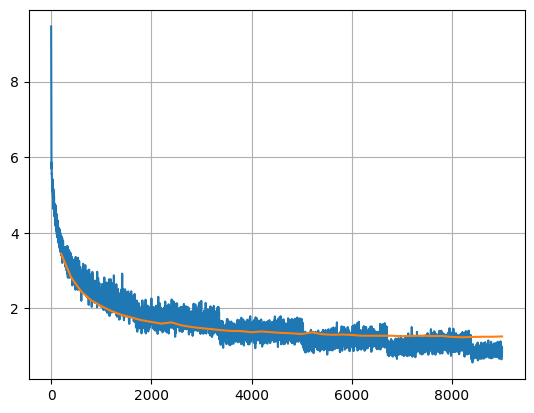

In [29]:
plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val")
plt.grid()
plt.show()

## 推理

- 翻译项目的评估指标一般是BLEU4，感兴趣的同学自行了解并实现
- 接下来进行翻译推理，并作出注意力的热度图

In [27]:
!ls checkpoints/translate-seq2seq

best.ckpt


In [28]:
# load checkpoints,如何上线
model = Sequence2Sequence(len(src_word2idx), len(trg_word2idx))
model.load_state_dict(torch.load(f"./checkpoints/translate-seq2seq/best.ckpt", map_location="cpu"))

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        self.model = model
        self.model.eval() # 切换到验证模式
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def draw_attention_map(self, scores, src_words_list, trg_words_list):
        """绘制注意力热力图

        Args:
            - scores (numpy.ndarray): shape = [source sequence length, target sequence length]
        """
        plt.matshow(scores.T, cmap='viridis') # 注意力矩阵,显示注意力分数值
        # 获取当前的轴
        ax = plt.gca()

        # 设置热图中每个单元格的分数的文本
        for i in range(scores.shape[0]): #输入
            for j in range(scores.shape[1]): #输出
                ax.text(j, i, f'{scores[i, j]:.2f}',  # 格式化数字显示
                               ha='center', va='center', color='k')

        plt.xticks(range(scores.shape[0]), src_words_list)
        plt.yticks(range(scores.shape[1]), trg_words_list)
        plt.show()

    def __call__(self, sentence):
        sentence = preprocess_sentence(sentence) # 预处理句子，标点符号处理等
        encoder_input, attn_mask = self.src_tokenizer.encode(
            [sentence.split()],
            padding_first=True,
            add_bos=True,
            add_eos=True,
            return_mask=True,
            ) # 对输入进行编码，并返回encode_piadding_mask
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64) # 转换成tensor

        preds, scores = model.infer(encoder_input=encoder_input, attn_mask=attn_mask) #预测

        trg_sentence = self.trg_tokenizer.decode([preds], split=True, remove_eos=False)[0] #通过tokenizer转换成文字

        src_decoded = self.src_tokenizer.decode(
            encoder_input.tolist(),
            split=True,
            remove_bos=False,
            remove_eos=False
            )[0] #对输入编码id进行解码，转换成文字,为了画图

        self.draw_attention_map(
            scores.squeeze(0).numpy(),
            src_decoded, # 注意力图的源句子
            trg_sentence # 注意力图的目标句子
            )
        return " ".join(trg_sentence[:-1])




/tmp/ipykernel_300/788989974.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"./checkpoints/translate-seq2seq/best.ckpt", map_location=

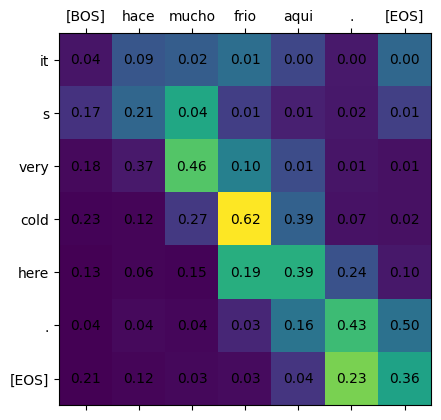

'it s very cold here .'

In [29]:
translator = Translator(model.cpu(), src_tokenizer, trg_tokenizer)
translator(u'hace mucho frio aqui .')

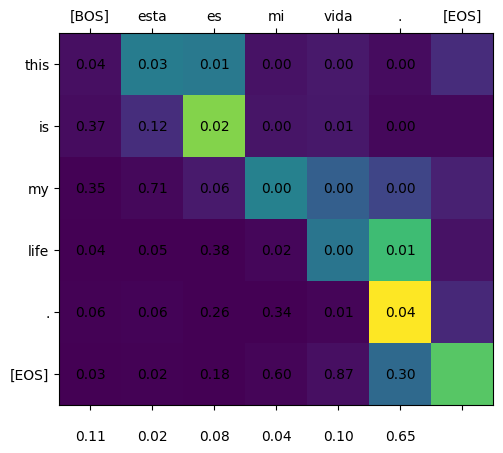

'this is my life .'

In [35]:
translator(u'esta es mi vida.')

In [34]:
for i in test_ds:
    print(i)
    break

('hola .', 'hi .')


/tmp/ipykernel_300/2788061694.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"./checkpoints/translate-seq2seq/best.ckpt", map_location

In [52]:
model = Sequence2Sequence(len(src_word2idx), len(trg_word2idx))
model.load_state_dict(torch.load(f"./checkpoints/translate-seq2seq/best.ckpt", map_location="cpu"))

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        self.model = model
        self.model.eval() # 切换到验证模式
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def __call__(self, sentence):
        sentence = preprocess_sentence(sentence) # 预处理句子，标点符号处理等
        encoder_input, attn_mask = self.src_tokenizer.encode(
            [sentence.split()],
            padding_first=True,
            add_bos=True,
            add_eos=True,
            return_mask=True,
            ) # 对输入进行编码，并返回encode_piadding_mask
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64) # 转换成tensor

        preds, scores = model.infer(encoder_input=encoder_input, attn_mask=attn_mask) #预测

        trg_sentence = self.trg_tokenizer.decode([preds], split=True, remove_eos=False)[0] #通过tokenizer转换成文字

        return " ".join(trg_sentence[:-1])

from nltk.translate.bleu_score import sentence_bleu

def evaluate_bleu_on_test_set(test_data, translator):
    """
    在测试集上计算平均 BLEU 分数。
    :param test_data: 测试集数据，格式为 [(src_sentence, [ref_translation1, ref_translation2, ...]), ...]
    :param translator: 翻译器对象（Translator 类的实例）
    :return: 平均 BLEU 分数
    """
    total_bleu = 0.0
    num_samples = len(test_data)
    i=0
    for src_sentence, ref_translations in test_data:
        # 使用翻译器生成翻译结果
        candidate_translation = translator(src_sentence)

        # 计算 BLEU 分数
        bleu_score = sentence_bleu([ref_translations.split()], candidate_translation.split(),weights=(1, 0, 0, 0))
        total_bleu += bleu_score

        # 打印当前句子的 BLEU 分数（可选）
        # print(f"Source: {src_sentence}")
        # print(f"Reference: {ref_translations}")
        # print(f"Candidate: {candidate_translation}")
        # print(f"BLEU: {bleu_score:.4f}")
        # print("-" * 50)
        # i+=1
        # if i>10:
        #     break
    # 计算平均 BLEU 分数
    avg_bleu = total_bleu / num_samples
    return avg_bleu
translator = Translator(model.cpu(), src_tokenizer, trg_tokenizer)
evaluate_bleu_on_test_set(test_ds, translator)

/tmp/ipykernel_300/472989537.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"./checkpoints/translate-seq2seq/best.ckpt", map_location=

0.7082455254952078